In [47]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
from tabulate import tabulate


from trainer import Trainer, generate_data_iter
import utils
import attack
import cam

In [48]:
model_mode, dataset, seed, cuda = 'mobilenetv3_large_100', 'Imagenette', 2, 0
target_layer = 'layer4' if model_mode == 'resnet18' else 'blocks'
fig_num = 100
metrics = {}

utils.set_random_seed(seed)
trainer = Trainer(
    model_mode = model_mode,
    dataset = dataset,
    bs = 128,
    lr = 0.01,
    seed = seed,
    cuda = cuda,
    use_lr_sche = True,
    use_wandb = False,
)

trainer.load()
scorecam = cam.ScoreCAM(trainer.model, dataset, target_layer, cuda = cuda)

import os
metric_pth = f'./thesis/attack_metrics/{dataset}/'
if not os.path.exists(metric_pth):
    os.makedirs(metric_pth)
    
attack_pth = f'./thesis/attack_pics/{dataset}/'
if not os.path.exists(attack_pth):
    os.makedirs(attack_pth)

# Generate Test data
test_iter = generate_data_iter(dataset, batch_size = fig_num, mode = 'test')
imgs, labels = next(iter(test_iter))
raw_cam_nps, raw_preds, _, __ = scorecam(imgs, metric = False)

# Extract Successful Results
suc_indices = raw_preds == labels
suc_imgs, suc_labels = imgs[suc_indices], labels[suc_indices]
suc_cams, suc_saliency_maps, suc_preds, suc_probs, suc_cam_metrics \
    = scorecam(suc_imgs, metric = True, saliency = True)


metrics['Raw'] = {
    'time': 0,
    'success_rate': 1,
    'delta_norm': 0,
    'Average Incr': suc_cam_metrics['Average Incr'], 
    'Average Drop': suc_cam_metrics['Average Drop'],
    'Insertion':  suc_cam_metrics['Insertion'], 
    'Deletion': suc_cam_metrics['Deletion'],
    'saliency_diff': 0,
    'shift_dist': 0
}
print(tabulate(
    list(metrics['Raw'].items()), tablefmt ='orgtbl'
))

| time          | 0        |
| success_rate  | 1        |
| delta_norm    | 0        |
| Average Incr  | 0.212121 |
| Average Drop  | 0.266827 |
| Insertion     | 0.802997 |
| Deletion      | 0.513244 |
| saliency_diff | 0        |
| shift_dist    | 0        |


In [49]:
def test_advatt(att, max_iter: int = None, att_kwargs: dict = {}):
    start = time.time()
    att_imgs = att(
        suc_imgs, suc_labels, max_iter = max_iter, 
        num_classes = 10, attack_kwargs = att_kwargs
    )
    finish = time.time()
    deltas = att_imgs - suc_imgs
    
    att_preds, _ = scorecam.model_predict(scorecam.tfm(att_imgs))
    
    # Success Rate
    indices = att_preds != suc_labels
    success_rate = indices.sum() / len(att_preds)

    # delta norm
    delta_norm = torch.mean(
        torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
            / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
    )
    
    # In cam part, we only focus on successful part
    att_suc_cams, att_suc_saliency, _, __, att_suc_cam_metrics \
        = scorecam(att_imgs[indices], metric = True, saliency = True)

    # delta saliency map norm
    saliency_diff = np.linalg.norm(
        att_suc_saliency - suc_saliency_maps[indices.numpy()],
        axis = (1, 2)
    ).mean()

    # maximum shift
    size = imgs.shape[-1]
    suc_max_idx_raw = np.argmax(
        suc_saliency_maps[indices.numpy()].reshape(indices.sum(), -1), axis = 1
    )
    suc_max_x, suc_max_y = suc_max_idx_raw // size, suc_max_idx_raw % size

    att_max_idx_raw = np.argmax(att_suc_saliency.reshape(len(att_suc_saliency), -1), axis = 1)
    att_max_x, att_max_y = att_max_idx_raw // size, suc_max_idx_raw % size
    shift_dist = np.sqrt((att_max_x - suc_max_x)**2 + (att_max_y - suc_max_y)**2).mean()
    
    metrics = {
        'time': finish - start,
        'success_rate': success_rate.item(),
        'delta_norm': delta_norm.item(),
        'Average Incr': att_suc_cam_metrics['Average Incr'], 
        'Average Drop': att_suc_cam_metrics['Average Drop'],
        'Insertion':  att_suc_cam_metrics['Insertion'], 
        'Deletion': att_suc_cam_metrics['Deletion'],
        'saliency_diff': saliency_diff,
        'shift_dist': shift_dist
    }
    att_name = att.__class__.__name__
    np.save(attack_pth + f'{att_name}-{dataset}-{model_mode}-seed{seed}.npy', att_imgs.numpy())
    return att_imgs, att_suc_cams, indices.numpy(), metrics

def plot_imgs(
    raw_img: torch.Tensor,
    att_img: torch.Tensor,
    suc_cam: np.ndarray,
    att_cam: np.ndarray
):
    fig = plt.figure(figsize = (12, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(np.transpose(raw_img.numpy(), (1, 2, 0)))
    plt.title('Raw')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(np.transpose(att_img.numpy(), (1, 2, 0)))
    plt.title('Attack')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(suc_cam)
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(att_cam)
    plt.axis('off')

### FGSM

In [50]:
att = attack.FGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.02}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 99/99 [00:01<00:00, 52.65it/s]


| time          |  1.88237  |
| success_rate  |  0.575758 |
| delta_norm    |  0.039736 |
| Average Incr  |  0.385965 |
| Average Drop  |  0.305179 |
| Insertion     |  0.563274 |
| Deletion      |  0.298359 |
| saliency_diff | 45.4513   |
| shift_dist    | 49.8947   |


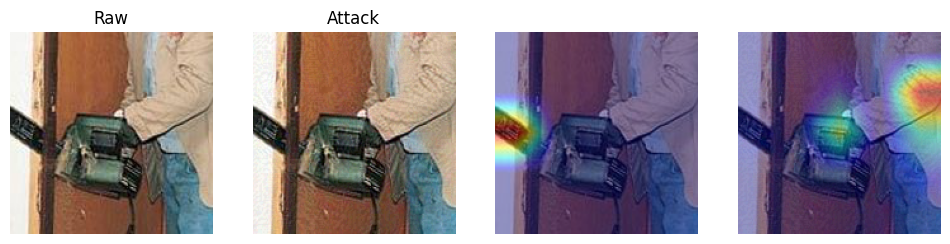

In [51]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### FGM

In [52]:
att = attack.FGM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 5}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 99/99 [00:01<00:00, 50.01it/s]


| time          |  1.98168   |
| success_rate  |  0.575758  |
| delta_norm    |  0.0357278 |
| Average Incr  |  0.438596  |
| Average Drop  |  0.274436  |
| Insertion     |  0.572562  |
| Deletion      |  0.301975  |
| saliency_diff | 46.3516    |
| shift_dist    | 47.8246    |


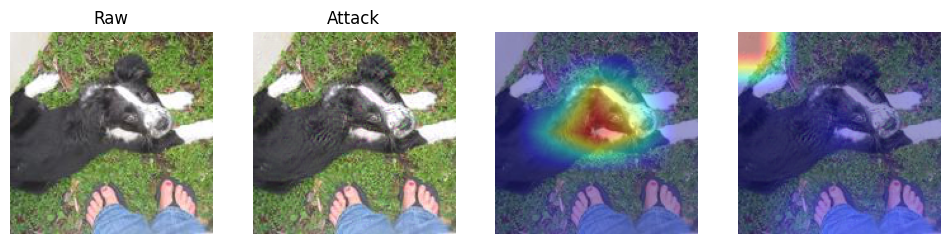

In [53]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### Step-LL

In [54]:
att = attack.StepLL(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.02}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 99/99 [00:02<00:00, 34.34it/s]


| time          |  2.88671   |
| success_rate  |  0.484848  |
| delta_norm    |  0.0397353 |
| Average Incr  |  0.5625    |
| Average Drop  |  0.228881  |
| Insertion     |  0.512766  |
| Deletion      |  0.188534  |
| saliency_diff | 48.6196    |
| shift_dist    | 46.4167    |


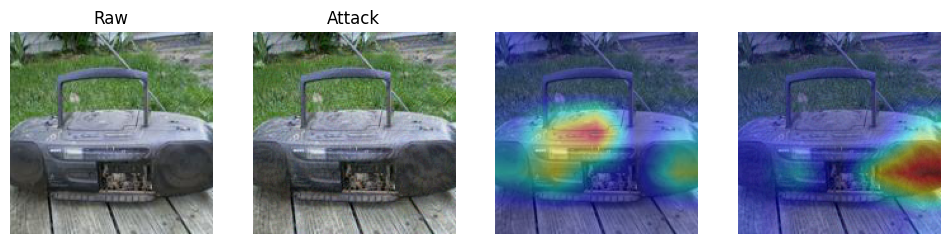

In [55]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### I-FGSM

In [56]:
att = attack.IFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.01}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 99/99 [00:19<00:00,  5.05it/s]


| time          | 19.5925    |
| success_rate  |  0.989899  |
| delta_norm    |  0.0322186 |
| Average Incr  |  0.0204082 |
| Average Drop  |  0.58006   |
| Insertion     |  0.642252  |
| Deletion      |  0.492206  |
| saliency_diff | 43.7546    |
| shift_dist    | 52.3673    |


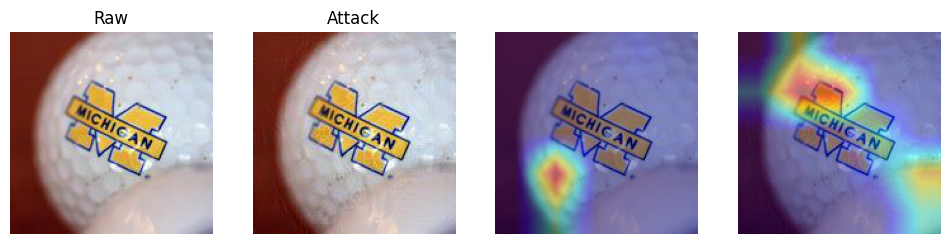

In [57]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### MI-FGSM

In [58]:
att = attack.MIFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.01}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 99/99 [00:20<00:00,  4.81it/s]


| time          | 20.5671    |
| success_rate  |  0.989899  |
| delta_norm    |  0.0331106 |
| Average Incr  |  0.0306122 |
| Average Drop  |  0.583399  |
| Insertion     |  0.639264  |
| Deletion      |  0.502076  |
| saliency_diff | 44.1337    |
| shift_dist    | 54.2245    |


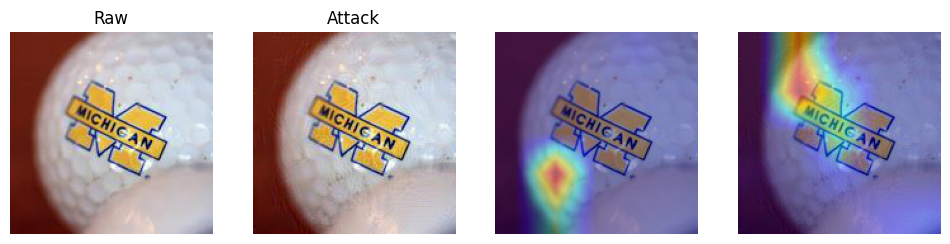

In [59]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### NIFGSM

In [60]:
att = attack.NIFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.01}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 99/99 [00:20<00:00,  4.94it/s]


| time          | 20.0354    |
| success_rate  |  0.989899  |
| delta_norm    |  0.0331086 |
| Average Incr  |  0.0306122 |
| Average Drop  |  0.590022  |
| Insertion     |  0.620469  |
| Deletion      |  0.516994  |
| saliency_diff | 43.4543    |
| shift_dist    | 52.1837    |


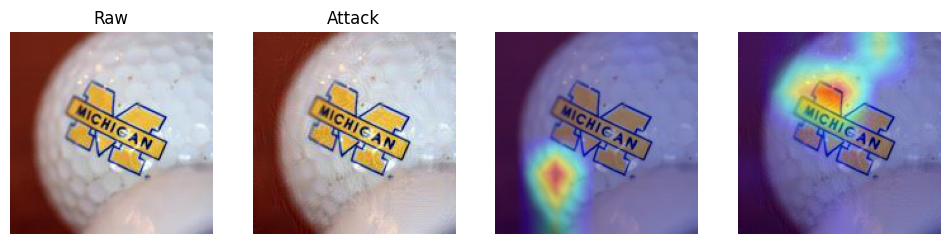

In [61]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### PGD

In [62]:
att = attack.PGD(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.02}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 99/99 [00:20<00:00,  4.86it/s]


| time          | 20.3577    |
| success_rate  |  0.989899  |
| delta_norm    |  0.0307826 |
| Average Incr  |  0.0102041 |
| Average Drop  |  0.559187  |
| Insertion     |  0.66603   |
| Deletion      |  0.496729  |
| saliency_diff | 43.2441    |
| shift_dist    | 53.602     |


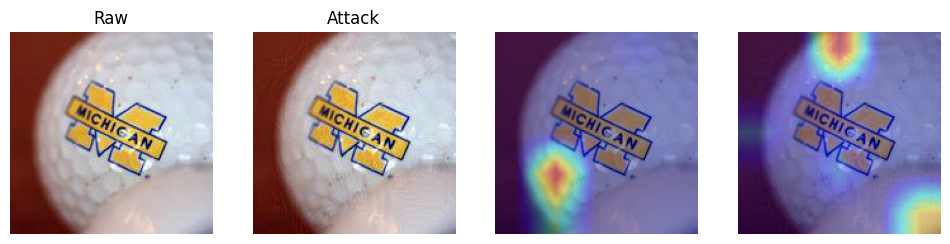

In [63]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### IterLL

In [64]:
att = attack.IterLL(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.012}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 99/99 [00:21<00:00,  4.71it/s]


| time          | 21.0196    |
| success_rate  |  0.909091  |
| delta_norm    |  0.0344715 |
| Average Incr  |  0.2       |
| Average Drop  |  0.558774  |
| Insertion     |  0.455705  |
| Deletion      |  0.227668  |
| saliency_diff | 45.2931    |
| shift_dist    | 47.0444    |


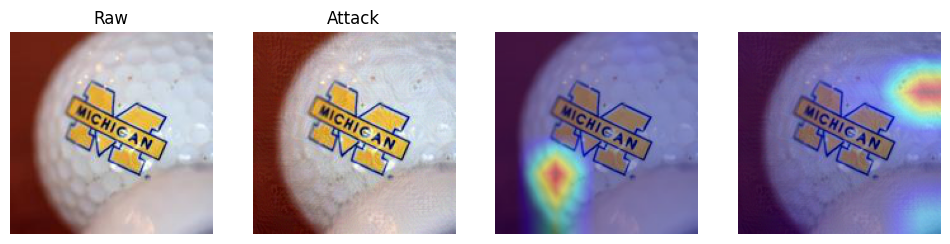

In [65]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### Deep Fool

In [66]:
att = attack.DeepFool(trainer.model, cuda)
att_name = att.__class__.__name__
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 99/99 [00:15<00:00,  6.58it/s]


| time          | 15.0449    |
| success_rate  |  0.747475  |
| delta_norm    |  0.0607792 |
| Average Incr  |  0.337838  |
| Average Drop  |  0.391257  |
| Insertion     |  0.567164  |
| Deletion      |  0.344734  |
| saliency_diff | 43.7637    |
| shift_dist    | 45.9189    |


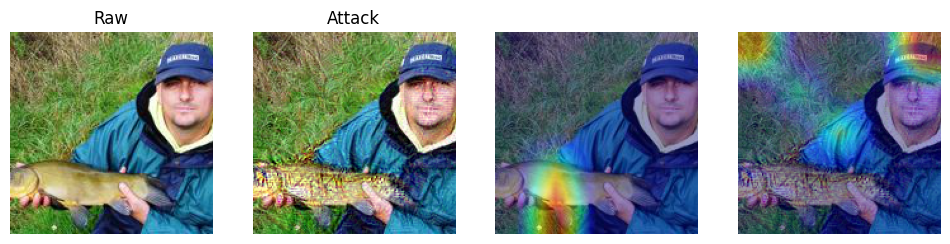

In [67]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### LBFGS

In [68]:
att = attack.LBFGS(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'c': 0.1}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 99/99 [06:33<00:00,  3.97s/it]


| time          | 393.483      |
| success_rate  |   0.171717   |
| delta_norm    |   0.00724642 |
| Average Incr  |   0.764706   |
| Average Drop  |   0.184806   |
| Insertion     |   0.677258   |
| Deletion      |   0.236234   |
| saliency_diff |  46.8186     |
| shift_dist    |  34.1176     |


In [69]:
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(metric_pth + f'Attack-{model_mode}-{dataset}-seed{seed}.csv')
metrics_df

,Raw,FGSM,FGM,StepLL,IFGSM,MIFGSM,NIFGSM,PGD,IterLL,DeepFool,LBFGS
time,0.000000,1.882366,1.981676,2.886705,19.592506,20.567138,20.035388,20.357690,21.019564,15.044861,393.483020
success_rate,1.000000,0.575758,0.575758,0.484848,0.989899,0.989899,0.989899,0.989899,0.909091,0.747475,0.171717
delta_norm,0.000000,0.039736,0.035728,0.039735,0.032219,0.033111,0.033109,0.030783,0.034471,0.060779,0.007246
Average Incr,0.212121,0.385965,0.438596,0.562500,0.020408,0.030612,0.030612,0.010204,0.200000,0.337838,0.764706
Average Drop,0.266827,0.305179,0.274436,0.228881,0.580060,0.583399,0.590022,0.559187,0.558774,0.391257,0.184806
Insertion,0.802997,0.563274,0.572562,0.512766,0.642252,0.639264,0.620469,0.666030,0.455705,0.567164,0.677258
Deletion,0.513244,0.298359,0.301975,0.188534,0.492206,0.502076,0.516994,0.496729,0.227668,0.344734,0.236234
saliency_diff,0.000000,45.451279,46.351589,48.619564,43.754604,44.133739,43.454250,43.244110,45.293076,43.763710,46.818634
shift_dist,0.000000,49.894737,47.824561,46.416667,52.367347,54.224490,52.183673,53.602041,47.044444,45.918919,34.117647
